In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Specify career len to export file for
# CAREER_LENGTH = 15
# Specify how long is the early career. Impacts which papers we take into account for early productivity and quality
EARLY_CAREER_LEN = 3
# For early career work, when do we stop counting citations. Impacts recognition
RECOGNITION_CUT_OFF = 5
# Success after 15 years. Impacts when we stop counting citations
SUCCESS_CUTOFF = 15
# Length of observed career for dropouts
# (1-3), middle career (4-9), late career (10-15)

# TODO: for multiple dropout intervals code does not work!!!
CAREER_LENGTH_DROPOUTS_LIST = [ (0, 15)] #(0, 3), (4, 9), (10, 15),
CAREER_LENGTH_DROPOUTS = 15
INACTIVE_TIME_DROPOUTS = 10

# Specify the first and last year we consider in our analysis
# TODO: Should we specify last start year? 
START_YEAR = 1970
# LAST_START_YEAR = 2018 - max(CAREER_LENGTH, CAREER_LENGTH_DROPOUTS)

In [3]:
assert(INACTIVE_TIME_DROPOUTS < CAREER_LENGTH_DROPOUTS), "Time observed for dropouts has to be smaller than the whole window!"

In [4]:
# assert(CAREER_LENGTH >= EARLY_CAREER_LEN), "Early career len too long"

## 1. Load data

In [5]:
authorPublicationData = pd.read_csv('./data/author_publications_2017_asiansAsNone.txt')

authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [6]:
print(authorPublicationData.shape)
authorPublicationData.drop_duplicates(subset=['author','pub_id'], inplace=True)
print(authorPublicationData.shape)

(9471668, 3)
(9467149, 3)


In [7]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone.txt')
authorCitationsData.head()

,id1,id2,year
0,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,5065f1e8-0e2e-4e20-9866-2b5067d321dc,1990
1,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,cf862fd8-9204-4e44-9639-2d067c247539,1990
2,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,f19127f8-3d3a-4a9e-9580-c1d3e1e05141,1990
3,03b1d66a-b1fc-4d99-9904-9405695cc2ae,09991de0-c00f-49cf-a88a-6515943b0843,1994
4,03b1d66a-b1fc-4d99-9904-9405695cc2ae,156173f6-35eb-44f6-bc75-7c205153b6f0,1994


In [8]:
print(authorCitationsData.shape)
authorCitationsData.drop_duplicates(inplace=True)
print(authorCitationsData.shape)

(25161834, 3)
(25161834, 3)


In [9]:
print('Authors#      - ',authorPublicationData['author'].nunique())
print('Years#        - ',authorPublicationData['year'].nunique())
print('Publications# - ',authorPublicationData['pub_id'].nunique())

Authors#      -  1704919
Years#        -  83
Publications# -  3078230


## 2. Criteria for author removal

In [10]:
groupByAuthor = authorPublicationData.groupby(['author'])

groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

In [11]:
authorGroupedData = groupByAuthorMinYearData.to_frame(name='start_year')
authorGroupedData['end_year'] = groupByAuthorMaxYearData
authorGroupedData['total_num_pub'] = groupByAuthorCountPublicationsData
authorGroupedData = authorGroupedData.reset_index()
print('Total rows -                ', authorGroupedData.shape)

authorGroupedData = authorGroupedData[authorGroupedData["start_year"] >= START_YEAR]
print('After removing all < 1970 - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.drop_duplicates()
print('After removing duplicates - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.dropna(how='any')
print("After droping na -          ", authorGroupedData.shape)

authorGroupedData.head()

Total rows -                 (1704919, 4)
After removing all < 1970 -  (1699352, 4)
After removing duplicates -  (1699352, 4)
After droping na -           (1699352, 4)


,author,start_year,end_year,total_num_pub
0,'maseka lesaoana,2001,2015,2
1,(max) zong-ming cheng,2009,2011,2
2,(zhou) bryan bai,2011,2012,2
3,a aart blokhuis,1992,2005,2
4,a ahrabian,2017,2017,1


In [12]:
# Adding 1 here to have career length be at least one. So 3 years career means year1, year2, year3.
authorGroupedData["career_length"] = authorGroupedData['end_year'] - authorGroupedData['start_year'] + 1

### Remove authors by career length

In [13]:
# print("Before career len removal -          ", authorGroupedData.shape)
# authorGroupedData = authorGroupedData[authorGroupedData['career_length'] >= CAREER_LENGTH]
# print("After  career len removal -          ", authorGroupedData.shape)

### Career length distribution

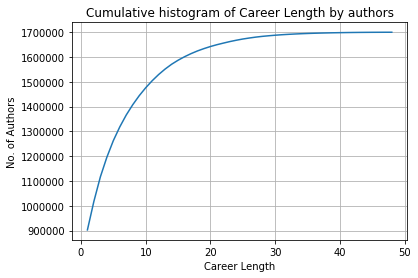

In [14]:
careerLengthDist = authorGroupedData.groupby(["career_length"])['author'].count()
temp = careerLengthDist.cumsum()  
ax = temp.plot(grid=True, title='Cumulative histogram of Career Length by authors')
ax.set_xlabel('Career Length')
ax.set_ylabel('No. of Authors')

plt.show()

In [15]:
credible_authors = authorGroupedData

### Label authors that drop out

In [16]:
print(f"Label authors with {INACTIVE_TIME_DROPOUTS} years inacitivity in a {CAREER_LENGTH_DROPOUTS} years window as dropouts")

Label authors with 10 years inacitivity in a 15 years window as dropouts


In [17]:
combined_pubs = authorPublicationData.merge(credible_authors[['author', 'start_year']], on='author', how='inner')

print(combined_pubs.head())
print(combined_pubs.shape)

        author  year                                pub_id  start_year
0  graeme earl  2011  001c58d3-26ad-46b3-ab3a-c1e557d16821        2009
1  graeme earl  2011  6af505cf-727f-47f9-afea-772af2928086        2009
2  graeme earl  2009  3ac1f00f-6830-42e9-b6f9-944f00a71b3c        2009
3  graeme earl  2009  3133714c-f979-4d84-9224-97361cf053ab        2009
4  graeme earl  2014  71d3749b-3e35-461b-86c8-920c42d5ebe8        2009
(9413377, 4)


In [18]:
CAREER_LENGTH_DROPOUTS_LIST

[(0, 15)]

In [19]:
#combined_pubs = combined_pubs.head(1000)

In [20]:
for start, end in CAREER_LENGTH_DROPOUTS_LIST:
    combined_pubs_grouped = combined_pubs[(combined_pubs.year >= combined_pubs.start_year + start) &
                                    (combined_pubs.year <= combined_pubs.start_year + end)]   
    # for every 2 consecutive years the author has published (nxt and prev) find a difference (absence time)
    # we artificially add a value: career start + 15 as a limiter of our observation window
    # this will add 0 values and reduce the mean for people who published in that year, but its maybe OK as we do it for all
    combined_pubs_grouped = combined_pubs_grouped.groupby('author')['year', 'start_year'].apply(
        lambda x: [nxt - prev for prev, nxt in zip(sorted(x['year']),sorted(x['year'].append(x['start_year']+end))[1:])])
    combined_pubs_grouped = combined_pubs_grouped.reset_index()
    combined_pubs_grouped.rename({0:f'absence_list-{start}-{end}'}, inplace=True, axis='columns')
    combined_pubs_grouped[f'max_absence-{start}-{end}'] = combined_pubs_grouped[f'absence_list-{start}-{end}'].apply(max)
    combined_pubs_grouped[f'avg_absence-{start}-{end}'] = combined_pubs_grouped[f'absence_list-{start}-{end}'].apply(np.mean)
    #break
    
    # TODO: Should i also add the start year into the calculation? Now i only have end year included

In [21]:
print(combined_pubs_grouped.head())
print(combined_pubs_grouped.shape)
print(combined_pubs_grouped[combined_pubs_grouped.author == "a min tjoa"])

                  author absence_list-0-15  max_absence-0-15  avg_absence-0-15
0       'maseka lesaoana           [14, 1]                14               7.5
1  (max) zong-ming cheng           [2, 13]                13               7.5
2       (zhou) bryan bai           [1, 14]                14               7.5
3        a aart blokhuis           [13, 2]                13               7.5
4             a ahrabian              [15]                15              15.0
(1699352, 4)
       author                              absence_list-0-15  \
9  a min tjoa  [7, 4, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]   

   max_absence-0-15  avg_absence-0-15  
9                 7               1.0  


In [22]:
credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length
0,'maseka lesaoana,2001,2015,2,15
1,(max) zong-ming cheng,2009,2011,2,3
2,(zhou) bryan bai,2011,2012,2,2
3,a aart blokhuis,1992,2005,2,14
4,a ahrabian,2017,2017,1,1


In [23]:
credible_authors = credible_authors.merge(combined_pubs_grouped[['author', 'max_absence-0-15', 'avg_absence-0-15']], on='author', how='left')
#credible_authors = credible_authors.merge(combined_pubs_15_y[['author', 'max_absence', 'avg_absence']], on='author', how='left')

credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15
0,'maseka lesaoana,2001,2015,2,15,14,7.5
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5
2,(zhou) bryan bai,2011,2012,2,2,14,7.5
3,a aart blokhuis,1992,2005,2,14,13,7.5
4,a ahrabian,2017,2017,1,1,15,15.0


In [24]:
credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15
0,'maseka lesaoana,2001,2015,2,15,14,7.5
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5
2,(zhou) bryan bai,2011,2012,2,2,14,7.5
3,a aart blokhuis,1992,2005,2,14,13,7.5
4,a ahrabian,2017,2017,1,1,15,15.0


In [25]:
credible_authors['dropped_after_10'] = credible_authors['max_absence-0-15'].apply(lambda x: False if x < 10 else True)

In [26]:
credible_authors['max_absence-0-15'].value_counts(dropna=False)

15    915304
14    118959
13    103782
12     84939
11     74752
10     66023
9      61777
8      60327
7      47302
6      42319
5      36687
4      32426
3      27540
2      21247
1       5968
Name: max_absence-0-15, dtype: int64

In [27]:
credible_authors.shape

(1699352, 8)

In [28]:
credible_authors['dropped_after_10'].value_counts()

True     1363759
False     335593
Name: dropped_after_10, dtype: int64

### Gender

In [29]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')


credible_authors = credible_authors.merge(gender, left_on='author', right_on='name', how='left')

credible_authors.drop('name', axis=1, inplace=True)

credible_authors.head()

credible_authors.gender.value_counts()

m       793766
none    650086
f       255500
Name: gender, dtype: int64

### Save filtered data about authors

In [30]:
print(credible_authors.head())
# credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv',
#                     index=False, encoding='utf-8')
credible_authors.to_csv('derived-data/authors-scientific.csv',
                    index=False, encoding='utf-8')

                  author  start_year  end_year  total_num_pub  career_length  \
0       'maseka lesaoana        2001      2015              2             15   
1  (max) zong-ming cheng        2009      2011              2              3   
2       (zhou) bryan bai        2011      2012              2              2   
3        a aart blokhuis        1992      2005              2             14   
4             a ahrabian        2017      2017              1              1   

   max_absence-0-15  avg_absence-0-15  dropped_after_10 gender  
0                14               7.5              True   none  
1                13               7.5              True   none  
2                14               7.5              True   none  
3                13               7.5              True   none  
4                15              15.0              True   none  


In [31]:
m_credible_authors = credible_authors[credible_authors["gender"] == "m"]
f_credible_authors = credible_authors[credible_authors["gender"] == "f"]
print(np.percentile(m_credible_authors["max_absence-0-15"].values, [25, 50, 75, 100]))
print(np.percentile(f_credible_authors["max_absence-0-15"].values, [25, 50, 75, 100]))
print(np.mean(m_credible_authors["max_absence-0-15"].values))
print(np.std(m_credible_authors["max_absence-0-15"].values))
print(np.mean(f_credible_authors["max_absence-0-15"].values))
print(np.std(f_credible_authors["max_absence-0-15"].values))


# Quick load
# credible_authors = pd.read_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


[10. 15. 15. 15.]
[12. 15. 15. 15.]
12.394678028537378
3.67496992609053
13.003937377690802
3.2483251978504835


### Remove author from publications

In [32]:
print(authorPublicationData.shape)

(9467149, 3)


In [33]:
authorPublicationData_cleaned = authorPublicationData.loc[authorPublicationData.author.isin(credible_authors.author)]

In [34]:
print(authorPublicationData_cleaned.shape)

(9413377, 3)


In [35]:
# authorPublicationData_cleaned.to_csv('derived-data/author-publications-atleast-'+ str(CAREER_LENGTH)+'-year.csv', index=False)
authorPublicationData_cleaned.to_csv('derived-data/author-publications.csv', index=False)

In [ ]:
# Quick load
# authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+ str(CAREER_LENGTH)+'-year.csv')

## 3. Generate a new citation network

### Generate Author->Paper network

In [36]:
# We need data about how many times an author has been cited
# For every authors publication, i merge all citations
final_citation_count_from_ids = authorPublicationData.merge(authorCitationsData, left_on='pub_id', 
                                                            right_on='id2', how='inner', suffixes=('_pub', '_cit'))

In [37]:
print(final_citation_count_from_ids.shape)

(75912535, 6)


In [38]:
final_citation_count_from_ids.drop_duplicates(inplace=True)

In [39]:
print(final_citation_count_from_ids.shape)

(75912535, 6)


#### Remove errors in citation data (years published vs years cited)

In [40]:
# Published before cited - NORMAL
print(final_citation_count_from_ids.shape)
num_normal = final_citation_count_from_ids[final_citation_count_from_ids.year_pub <= final_citation_count_from_ids.year_cit].shape
print(num_normal)

(75912535, 6)
(75392625, 6)


In [41]:
# Published after cited - WRONG
num_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].shape
print(num_wrong)

(519910, 6)


In [42]:
print("Percentage of citations to be removed: ", num_wrong[0]*100/(num_normal[0]+num_wrong[0]))
print("Less than one percent")

Percentage of citations to be removed:  0.6848803033649186
Less than one percent


In [43]:
cit_wrong_df = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit]

In [44]:
cit_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].index

In [45]:
final_citation_count_from_ids.drop(cit_wrong, inplace=True)

assert num_normal[0] == final_citation_count_from_ids.shape[0], "The number of citations doesnt match"

In [46]:
final_citation_count_from_ids.columns

Index(['author', 'year_pub', 'pub_id', 'id1', 'id2', 'year_cit'], dtype='object')

#### Save

In [47]:
# final_citation_count_from_ids.to_csv('./data/authors_cited_by_papers_2017_asiansAsNone_by_daniel.txt',
#                                      columns=['author', 'year_pub', 'pub_id', 'id1', 'year_cit'], index=False)

final_citation_count_from_ids[['author', 'id1', 'id2', 'year_cit']].drop_duplicates().to_csv('derived-data/author-paper-citations-cleaned.csv', 
                                                                                   index=False)

# final_citation_count_from_ids.drop_duplicates(subset=['author_cited', 'pub_id_cited', 'pub_id_citing', 'author_citing'],
#                                               inplace=True)

In [48]:
# Quick load
# final_citation_count_from_ids = pd.read_csv('derived-data/paper-paper-citations-cleaned.csv')

In [49]:
# drop duplicates on id1,id2 because we only care about paper->paper citations
paper_citation_count = final_citation_count_from_ids.drop_duplicates(subset=['id1', 'id2']).groupby('id2')['id1'].count()
paper_citation_count.to_csv('derived-data/paper-citation-count.csv')

Its important to keep using this file for citations. As it has bad entries removed

### Generate Author->Author network

In [50]:
# # To generate an author->author citation network
# # For every citation an author received, merge in all the authors that cited him
# # TODO Should we be filtering citations? Do we include them all? We do drop ones cited before published
# final_citation_count_from_ids = final_citation_count_from_ids.merge(authorPublicationData, left_on='id1', 
#                                                                     right_on='pub_id', how='left', suffixes=('_cited', '_citing'))
# final_citation_count_from_ids.to_csv('./derived-data/author-author-citations.csv',
#                                      columns=['author_cited', 'author_citing', 'year_cit'], index=False)

In [51]:
final_citation_count_from_ids.head()

,author,year_pub,pub_id,id1,id2,year_cit
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013
3,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44,001c8744-73c4-4b04-9364-22d31a10dbf1,2014
4,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013


### Group citations over authors and years

In [52]:
citations_year_auth = final_citation_count_from_ids.groupby(['author', 'year_cit'])['id1'].count()


In [53]:
citations_year_auth.head()

author            year_cit
'maseka lesaoana  2002        1
                  2003        1
                  2004        1
                  2005        2
                  2006        4
Name: id1, dtype: int64

In [54]:
# TODO: Why am i merging num_pub here? Why merge credible authors? Maybe i was making one file to use in both cases
# citations_year_auth = citations_year_auth.reset_index().merge(credible_authors[['author', 'total_num_pub']], on='author')

In [56]:
citations_year_auth = citations_year_auth.reset_index()
citations_year_auth = citations_year_auth.rename(columns={'id1':'cit_count'})

# citations_year_auth[['author', 'year_cit', 'cit_count']].to_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv', index=False)
citations_year_auth[['author', 'year_cit', 'cit_count']].to_csv('derived-data/authors-perYear-citations.csv', index=False)

In [57]:
citations_year_auth = citations_year_auth.groupby(['author', 'year_cit'])['cit_count'].sum()

## Early career analysis

In [58]:
# credible authors contains only a fraction of all authors!
# merging inner here will remove citations from uncredible authors?
combined = final_citation_count_from_ids.merge(credible_authors[['author', 'start_year']], on='author', how='inner')

In [59]:
combined.shape

(74452472, 7)

In [60]:
combined.head()

,author,year_pub,pub_id,id1,id2,year_cit,start_year
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015,2009
1,graeme earl,2011,6af505cf-727f-47f9-afea-772af2928086,7be205bf-95e7-4baa-b800-770684720dec,6af505cf-727f-47f9-afea-772af2928086,2014,2009
2,graeme earl,2009,3ac1f00f-6830-42e9-b6f9-944f00a71b3c,523e22e9-0b2f-439f-bad6-dd8037364f44,3ac1f00f-6830-42e9-b6f9-944f00a71b3c,2010,2009
3,graeme earl,2009,3133714c-f979-4d84-9224-97361cf053ab,001c58d3-26ad-46b3-ab3a-c1e557d16821,3133714c-f979-4d84-9224-97361cf053ab,2011,2009
4,graeme earl,2009,3133714c-f979-4d84-9224-97361cf053ab,523e22e9-0b2f-439f-bad6-dd8037364f44,3133714c-f979-4d84-9224-97361cf053ab,2010,2009


In [61]:
combined.drop_duplicates(subset=['author', 'id1', 'id2'], inplace=True)

In [62]:
credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender
0,'maseka lesaoana,2001,2015,2,15,14,7.5,True,none
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5,True,none
2,(zhou) bryan bai,2011,2012,2,2,14,7.5,True,none
3,a aart blokhuis,1992,2005,2,14,13,7.5,True,none
4,a ahrabian,2017,2017,1,1,15,15.0,True,none


In [63]:
combined_early_degree = combined[(combined.year_pub < combined.start_year + EARLY_CAREER_LEN)]

combined_early_degree = combined_early_degree.drop_duplicates(subset=['author', 'pub_id'])

combined_early_degree = combined_early_degree[['author', 'pub_id']]

# authors_per_paper = combined_early_degree.groupby('pub_id')['author'].count().reset_index()
# authors_per_paper.rename({"author":"early_career_degree"}, axis='columns', inplace=True)

combined_early_degree = combined_early_degree.merge(combined_early_degree, on='pub_id')



In [64]:
combined_early_degree = combined_early_degree[combined_early_degree.author_x != combined_early_degree.author_y]
combined_early_degree = combined_early_degree.drop_duplicates(subset=['author_x', 'author_y'])

In [65]:
combined_early_degree[combined_early_degree.author_x == "paul michael walker"]

,author_x,pub_id,author_y
362393,paul michael walker,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,louis legrand
362395,paul michael walker,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,françois brunotte
362396,paul michael walker,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,alain lalande
362397,paul michael walker,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,france guy
362398,paul michael walker,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,yves cottin


In [66]:
combined_early_degree = combined_early_degree.groupby('author_x')['author_y'].count().reset_index()

In [67]:
combined_early_degree.rename({"author_x":"author", "author_y": "early_career_degree"}, axis='columns', inplace=True)

In [68]:
combined_early_degree.sample(10)

,author,early_career_degree
502217,muhammad faheem,1
594516,robert m. krauss,2
550348,per strid,2
40671,andreas kelle-emden,1
178571,eduarda pinto ferreira,1
664217,stephen j. wichmann,3
224659,gautam goel,1
439549,marc d. porter,2
235387,giuseppina di fruscio,2
447866,marie swall,7


In [69]:
authorPublicationData_cleaned[authorPublicationData_cleaned.pub_id == "b97e5d30-da7e-44cc-a5d9-d3a6d647e918"]

,author,year,pub_id
280173,marie-christine jaulent,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918
280174,paul michael walker,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918
280175,louis legrand,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918
280176,françois brunotte,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918
280177,alain lalande,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918
280178,france guy,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918
280179,yves cottin,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918


In [70]:
combined[combined.author == 'paul michael walker']

,author,year_pub,pub_id,id1,id2,year_cit,start_year
31936962,paul michael walker,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,ce139557-74ec-4406-8d07-6324f307e792,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,2013,1997
31936963,paul michael walker,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,1095281b-be50-4cc8-aab5-23cadf997068,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,2009,1997
31936964,paul michael walker,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,18c0a2a3-4b93-4c64-a660-f17fcd871370,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,2006,1997
31936965,paul michael walker,1997,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,fd294f9c-de8f-460b-8bfb-6f3e75704bae,b97e5d30-da7e-44cc-a5d9-d3a6d647e918,2000,1997
31936966,paul michael walker,2012,4ed64c8c-f744-474c-b8bb-e9782048b6f1,b9a724e9-4404-4e09-8d98-0be68fa5eae6,4ed64c8c-f744-474c-b8bb-e9782048b6f1,2014,1997
31936967,paul michael walker,2012,4ed64c8c-f744-474c-b8bb-e9782048b6f1,9278d78b-c344-448c-b30e-0e5681accfc0,4ed64c8c-f744-474c-b8bb-e9782048b6f1,2014,1997
31936968,paul michael walker,2012,4ed64c8c-f744-474c-b8bb-e9782048b6f1,ee493863-848d-492a-887f-94556950ee19,4ed64c8c-f744-474c-b8bb-e9782048b6f1,2013,1997
31936969,paul michael walker,2012,a89513b0-108d-49de-9463-8f3079df0328,7e4cef57-04c2-439b-8859-7b0aebebeb31,a89513b0-108d-49de-9463-8f3079df0328,2012,1997
31936970,paul michael walker,2012,a89513b0-108d-49de-9463-8f3079df0328,994124aa-8d8c-443f-bbf5-1fb5dbf52225,a89513b0-108d-49de-9463-8f3079df0328,2013,1997
31936971,paul michael walker,2012,a89513b0-108d-49de-9463-8f3079df0328,fabc9bcc-cd3f-45af-a047-84937fd0364d,a89513b0-108d-49de-9463-8f3079df0328,2015,1997


In [71]:
credible_authors = credible_authors.merge(combined_early_degree, on='author', how='left')
credible_authors['early_career_degree'] = credible_authors['early_career_degree'].fillna(0)

In [72]:
combined_early_quality = combined[(combined.year_pub < combined.start_year + EARLY_CAREER_LEN) &
         (combined.year_cit < combined.start_year + SUCCESS_CUTOFF)]

In [73]:
early_career_quality = combined_early_quality.groupby('author')['id1'].count()

early_career_quality = early_career_quality.rename('early_career_qual')
early_career_quality = early_career_quality.reset_index()
credible_authors = credible_authors.merge(early_career_quality, on='author', how='left')

In [74]:
credible_authors['early_career_qual'] = credible_authors['early_career_qual'].fillna(0)

In [75]:
early_career_recognition = combined[(combined.year_pub < combined.start_year + EARLY_CAREER_LEN) &
         (combined.year_cit < combined.start_year + RECOGNITION_CUT_OFF)]

In [76]:
early_career_recognition = early_career_recognition.groupby('author')['id1'].count()

early_career_recognition = early_career_recognition.rename('early_career_recognition')
early_career_recognition = early_career_recognition.reset_index()
credible_authors = credible_authors.merge(early_career_recognition, on='author', how='left')

In [77]:
credible_authors['early_career_recognition'] = credible_authors['early_career_recognition'].fillna(0)

In [78]:
combined_succ_after_15y = combined[combined.year_cit < combined.start_year + SUCCESS_CUTOFF]

In [79]:
succ_after_15y = combined_succ_after_15y.groupby('author')['id1'].count()

succ_after_15y = succ_after_15y.rename('succ_after_15y')
succ_after_15y = succ_after_15y.reset_index()
credible_authors = credible_authors.merge(succ_after_15y, on='author', how='left')
credible_authors['succ_after_15y'] = credible_authors['succ_after_15y'].fillna(0)

In [80]:
def get_early_career_prod(row, early_career_len):
    early_prod = 0
    author = row.author
    start_year = row['start_year']
    year_num_pub = author_year_numPub[author]
    for year in range(early_career_len):
        if start_year + year in year_num_pub:
            early_prod += year_num_pub[start_year + year]
    return early_prod

In [81]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [82]:
%%time
credible_authors['early_career_prod'] = credible_authors.apply(lambda x: get_early_career_prod(x, EARLY_CAREER_LEN), axis=1)

CPU times: user 17min 55s, sys: 12.3 s, total: 18min 7s
Wall time: 18min 8s


In [83]:
def get_early_publications(row, early_career_len):
    # TODO remove
    early_pubs = []
    author = row.author
    start_year = row['start_year']
    year_pub_list = author_year_publications[author]
    for year in range(early_career_len):
        if start_year + year in year_pub_list:
            early_pubs.extend(year_pub_list[start_year + year])
    return early_pubs

In [84]:
# author_year_publications = authorPublicationData.groupby(['author', 'year'])['pub_id'].apply(list)

In [85]:
# %%time
# credible_authors['early_career_pubs'] = credible_authors.apply(lambda x: get_early_publications(x, EARLY_CAREER_LEN), axis=1)

In [86]:
def get_early_career_recognition(row, early_career_len):
    # TODO remove
    early_rec = 0
    author = row.author
    start_year = row['start_year']
    if author in citations_year_auth:
        year_num_cit = citations_year_auth[author]
    else:
        return 0
    for year in range(early_career_len):
        if start_year + year in year_num_cit:
            early_rec += year_num_cit[start_year + year]
    return early_rec

In [87]:
# %%time
# credible_authors['early_career_rec'] = credible_authors.apply(lambda x: get_early_career_recognition(x, EARLY_CAREER_LEN), axis=1)

In [88]:
credible_authors[['author', 'start_year', 'end_year', 'early_career_qual', 'early_career_recognition']].sample(10)

,author,start_year,end_year,early_career_qual,early_career_recognition
742305,josé cardoso,2004,2013,6.0,5.0
1605705,xixun yu,2016,2017,5.0,5.0
644844,james meneely,1995,1995,2.0,2.0
1305144,s. simakhina,2012,2012,7.0,7.0
1130693,omkar pradhan,2013,2016,0.0,0.0
744172,josé m. urquiza,2001,2015,18.0,10.0
905437,m. d. burghardt,2015,2016,1.0,1.0
1600971,xin-rong chen,2016,2016,0.0,0.0
120750,antonios kalampakas,2003,2017,10.0,2.0
1662339,yukihiro iida,2000,2013,7.0,3.0


In [89]:
# final_citation_count = citations_year_auth.groupby('author')['cit_count'].sum()

# final_citation_count = final_citation_count.reset_index()

# credible_authors = credible_authors.merge(final_citation_count, on='author', how='left') 


# credible_authors.rename({'cit_count': 'final_citation_count'}, axis=1, inplace=True)

# credible_authors['final_citation_count'] = credible_authors['final_citation_count'].fillna(0)

## Save

In [90]:
# credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv',
#                     index=False, encoding='utf-8')
credible_authors.to_csv('derived-data/authors-scientific-extended.csv',
                    index=False, encoding='utf-8')